In [1]:
#
#   Fintech Final Project: Trading Strategy for SPY
#   Indicators.py
#
#   Written by Qhan
#   2017.12
#

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import talib as ta

#
#   Moving Average
#
def MA(close, period):
    decision = []
    MAs = ta.MA(close, period)
    for i in range(period, close.size):
        if close[i] > MAs[i]:
            decision.append([i, 1])
        else:
            decision.append([i, -1])
    return decision, MAs


def EMA(close, period): # exponential
    decision = []
    EMAs = ta.MA(close, period, matype=1)
    for i in range(period, close.size):
        if close[i] > EMAs[i]:
            decision.append([i, 1])
        else:
            decision.append([i, -1])
    return decision, EMAs


#
#   Stochastic Oscillator
#
def KD(data):
    high, low, close = np.array(data["High"]), np.array(data["Low"]), np.array(data["Close"])
    K, D = ta.STOCH(high, low, close)
    decision = []
    for i, (k, d) in enumerate(zip(K, D)):
        if k > d:
            decision.append([i, 1])
        else:
            decision.append([i, -1])
    return decision, K - D


#
#   Relative Strength Index
#
def RSI(close, period, upper=70, bottom=30):
    decision = []
    RSIs = ta.RSI(close, period)
    for i in range(period, RSIs.size):
        if RSIs[i] >= upper:
            decision.append([i, -1])
        elif RSIs[i] <= bottom:
            decision.append([i, 1])
        else:
            decision.append([i, 0])
    return decision, RSIs

            
#
#   Moving Average Convergence / Divergence
#
def MACD(close):
    decision = []
    diff, diff_ema, macd_hist = ta.MACD(close)
    for i in range(26, close.size):
        if macd_hist[i] > 0:
            decision.append([i, 1])
        else:
            decision.append([i, -1])
    return decision, macd_hist
            

#
#   Bias Ratio (Rate of Change)
#
def BIAS(close, period, upper=1, bottom=-1):
    decision = []
    BIAS = np.array(ta.ROC(close, period))
    real_bias = BIAS[period:]
    mean, std = np.mean(real_bias), np.std(real_bias)
    upper = mean + upper * std
    bottom = mean + bottom * std
    for i in range(period, BIAS.size):
        if BIAS[i] > upper:
            decision.append([i, -1])
        elif BIAS[i] < bottom:
            decision.append([i, 1])
        else:
            decision.append([i, 0])
    return decision, BIAS


#
#   Sharpe Ratio
#
def SR(close, period, upper=0.001, bottom=-0.001):
    decision = []
    ratios = []
    for i in range(period, close.size):
        mu = 0
        sigma = 0
        deltaS = []
        for j in range(i-period, i):
            ds = close[j+1] - close[j]
            mu += (ds / close[j])
            deltaS.append(ds)
        mu /= period
        for j, ds in zip(range(i-period, i), deltaS):
            sigma += (ds / close[j] - mu) ** 2
        sigma = (sigma / period) ** (1/2)
        ratio = mu / sigma
        ratios.append(ratio)
        if ratio > upper:
            decision.append([i, 1])
        elif ratio < bottom:
            decision.append([i, -1])
        else:
            decision.append([i, 0])
    return decision, ratios

In [2]:
#
#   Fintech Final Project: Trading Strategy for SPY
#   Utilities.py
#
#   Written by Qhan
#   2017.12
#

import pandas as pd
import numpy as np


def ReadData(filename):
    data = pd.read_csv(filename)
    return data


def Normalize(data):
    return ((data - data.mean()) / data.std())


def Evaluate(close, decision, initCapital, start_day=0):
    total_assets = []
    dec_size = len(decision)
    capital = initCapital
    total = capital
    units, d = 0, 0
    for i, price in enumerate(close):
        if d >= dec_size: break
        if i == int(decision[d][0]):
            action = decision[d][1]
            d += 1
            if i >= start_day:
                if action > 0 and units == 0:
                    units = capital / price
                    capital = 0
                elif action < 0 and units > 0:
                    capital = price * units
                    units = 0
        total = capital + price * units
        total_assets.append(total)
    print(total)
    return total_assets


def MergeDecision(decisions, weights, max_len):
    merged_decision = np.array([range(max_len), np.zeros(max_len)]).T
    for decision, weight in zip(decisions, weights):
        for d in decision:
            merged_decision[d[0]][1] += d[1] * weight
    return merged_decision


## Test Indicator and Plot Result

def PlotArea(ax, asset_history, baseline):
    for x, y in enumerate(asset_history):
        area = [(x-0.5, baseline), (x-0.5, y), (x+0.5, y), (x+0.5, baseline)]
        if y >= capital:
            poly = Polygon(area, facecolor='C0')
        else:
            poly = Polygon(area, facecolor='C3')
        ax.add_patch(poly)


def TestIndicator(data, indicator, capital=1000, periods=[5, 10, 20, 30, 60, 120, 240], 
                  days='all', savefig=False, showfig=True, start_day=0):
    print("Init Capital:", capital)
    values, assets = [], []
    multiple_periods_indicators = ["ma", "ema", "rsi", "sr", "bias"]
    close = np.array(data["Adj Close"])
    
    if indicator in multiple_periods_indicators:
        for p in periods:
            if indicator == "ma": decision, value = MA(close, p)
            elif indicator == "ema": decision, value = EMA(close, p)
            elif indicator == "rsi": decision, value = RSI(close, p)
            elif indicator == "bias": decision, value = BIAS(close, p)
            elif indicator == "sr": decision, value = SR(close, p)
            else: decision, value = [], []
            values.append(np.array(value))
            assets.append(np.array(Evaluate(close, decision, capital, start_day=start_day)))
    else:
        if indicator == "macd": decision, value = MACD(close)
        elif indicator == "kd": decision, value = KD(data)
        else: decision, value = [], []
        values.append(np.array(value))
        assets.append(np.array(Evaluate(close, decision, capital, start_day=start_day)))

    #
    #   draw values
    #
    plt.figure(figsize=(16, 16))
    plt.subplot(211)
    if len(values) > 1:
        for i, (value, p) in enumerate(zip(values, periods)):
            plt.plot(value[start_day:], label=indicator + str(p), linewidth='0.8')
    else:
        plt.plot(values[0][start_day:], label=indicator, linewidth='0.8')

    if indicator in ["sr", "kd", "macd", "bias"]: plt.axhline(y=0, color='C3')
    elif indicator is "rsi": plt.axhline(y=50, color='C3')
    plt.title(indicator.upper())
    plt.grid(linestyle='--')
    plt.legend()

    #
    #   draw asset history
    #
    plt.subplot(212)
    if len(assets) > 1:
        for i, (asset, p) in enumerate(zip(assets, periods)):
            plt.plot(asset[start_day:], label=indicator+"_asset" + str(p), linewidth='0.8')
    else:
        plt.plot(assets[0][start_day:], label=indicator+"_asset", color='k', linewidth='0.5')
        PlotArea(plt.gca(), assets[0][start_day:], capital)

    plt.axhline(y=capital, color="red")
    plt.title(indicator.upper() + " Assets")
    plt.grid(linestyle='--')
    plt.legend()
    if savefig: plt.gcf().savefig(days + "_" + indicator + ".png")
    if showfig: plt.show()

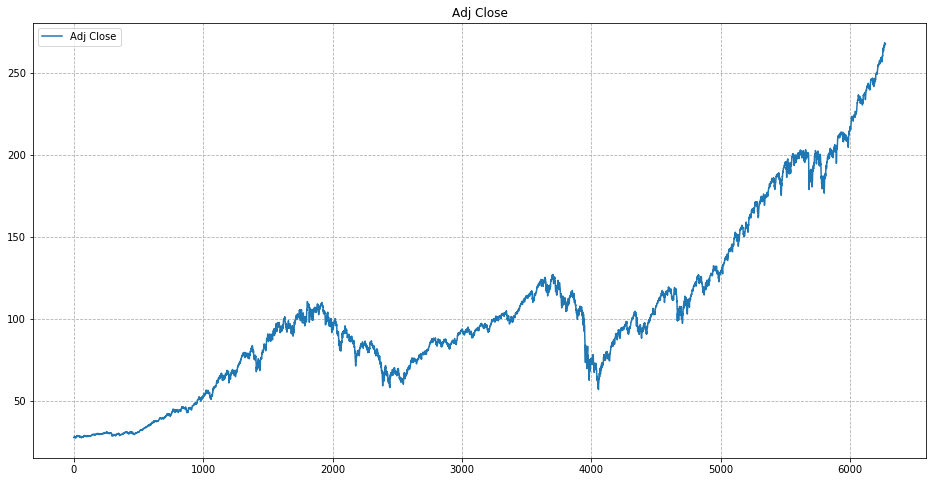

Init Capital: 1000
1129.64592701
1020.95868519
1663.10150595
2475.9818726
3046.20929521
3379.15786754
7149.0916041


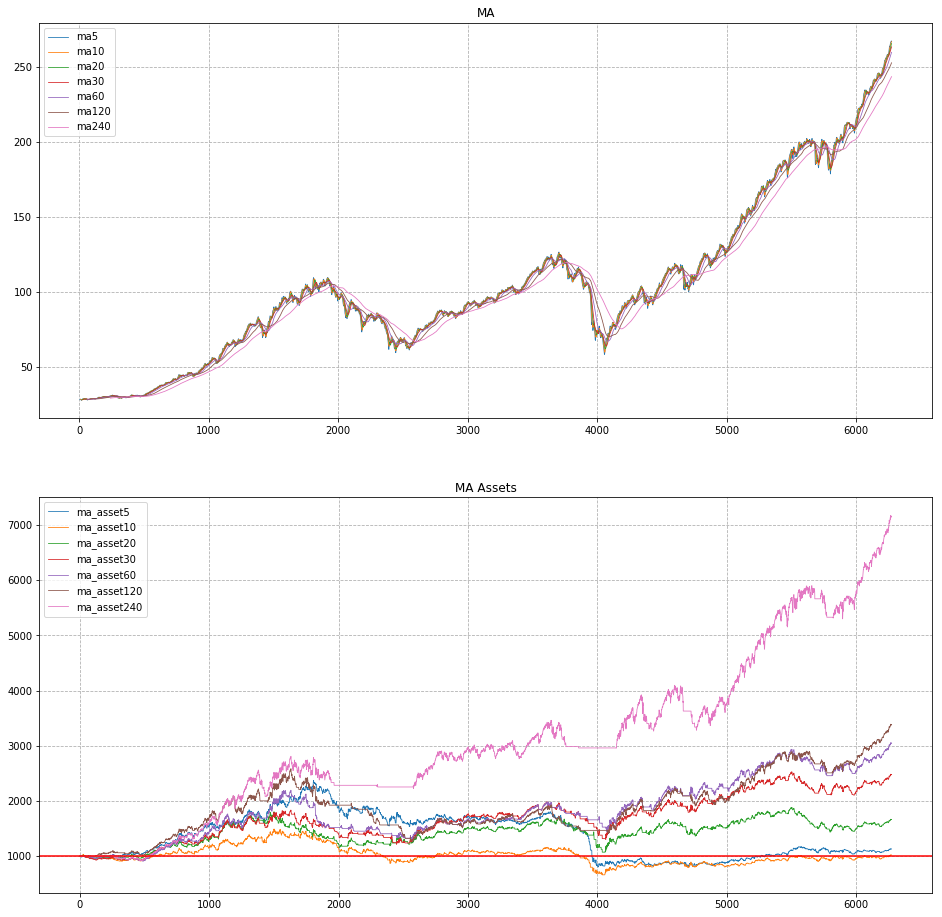

Init Capital: 1000
1205.76788172
1468.07812072
1994.15514073
2950.17340545
3928.68093318
5349.29423585
7382.06441036


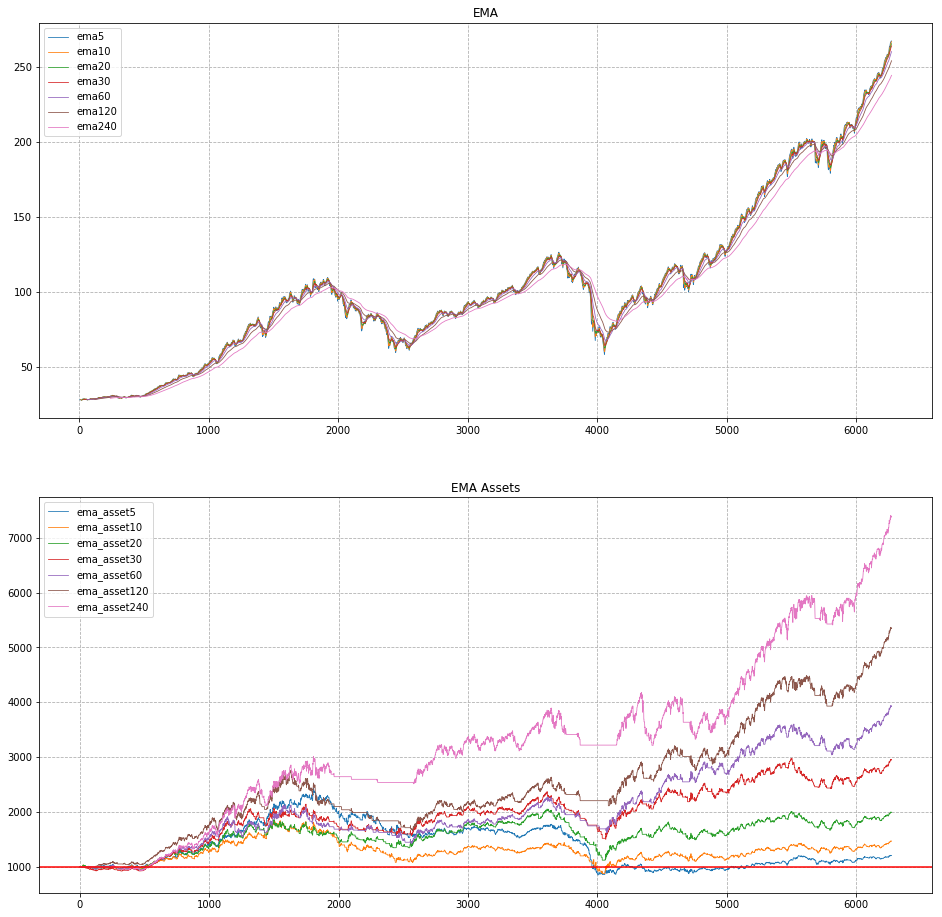

Init Capital: 1000
1759.37164639


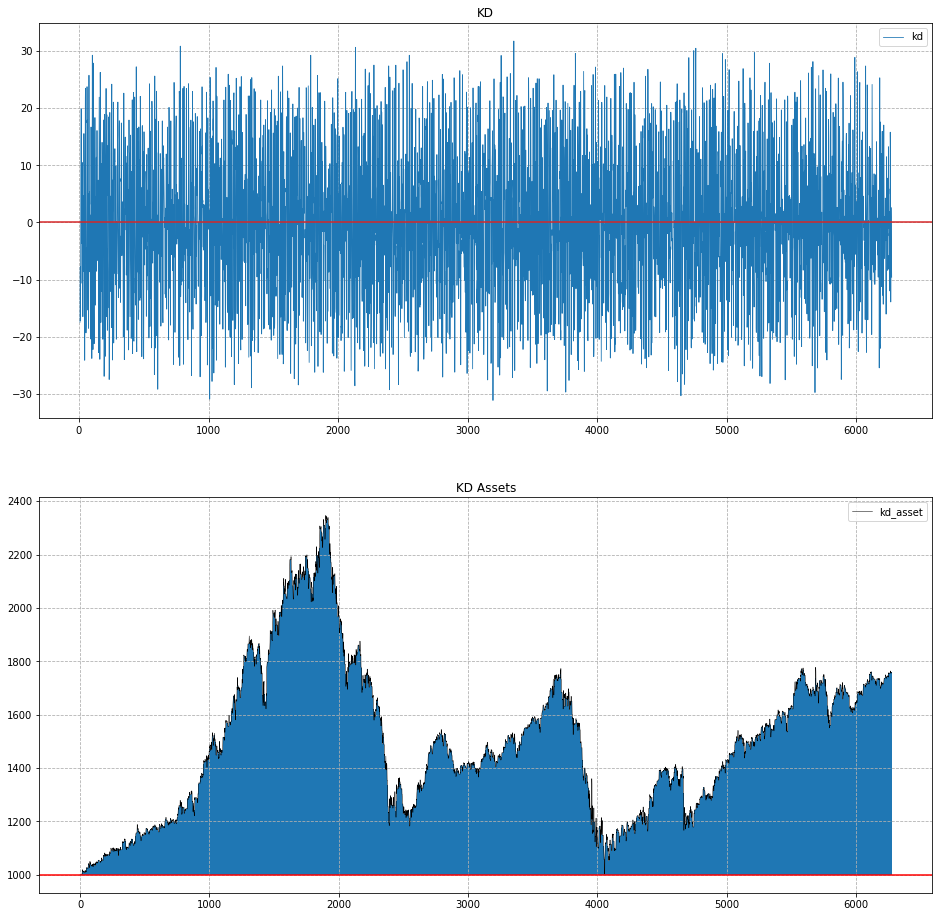

Init Capital: 1000
5614.2931954
3295.14311103
1209.8095894
4229.79133466
1000.0
1000.0
1000.0


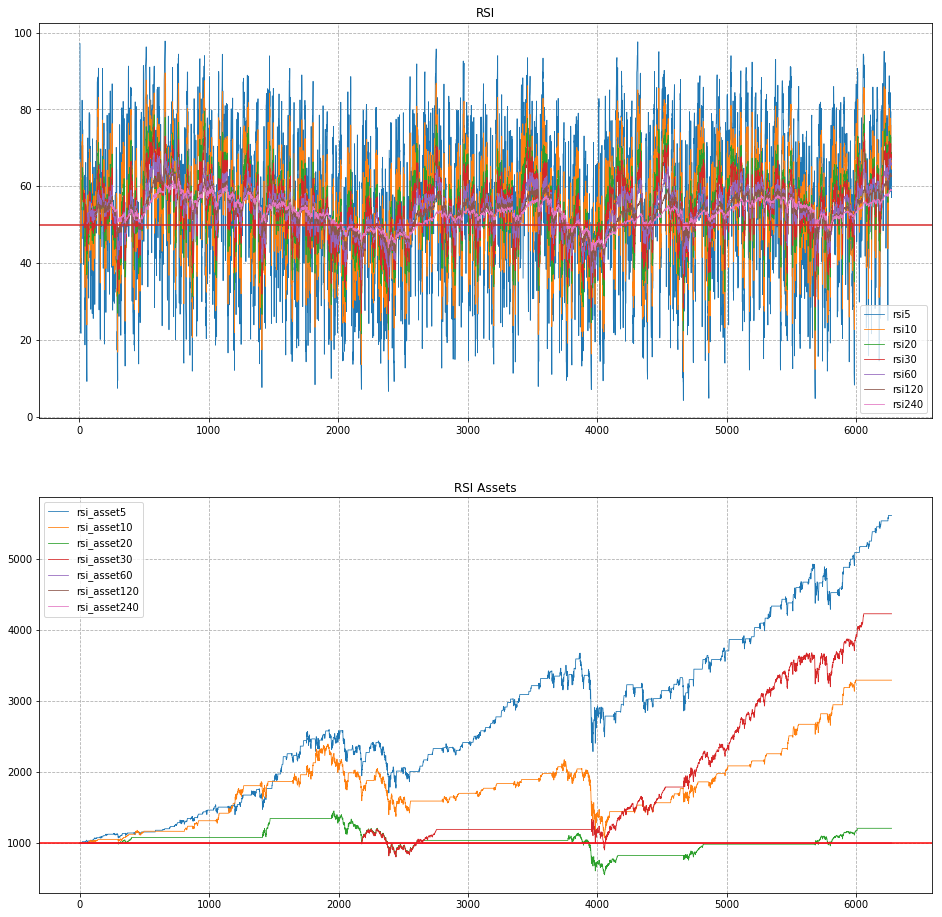

Init Capital: 1000
2053.31150038


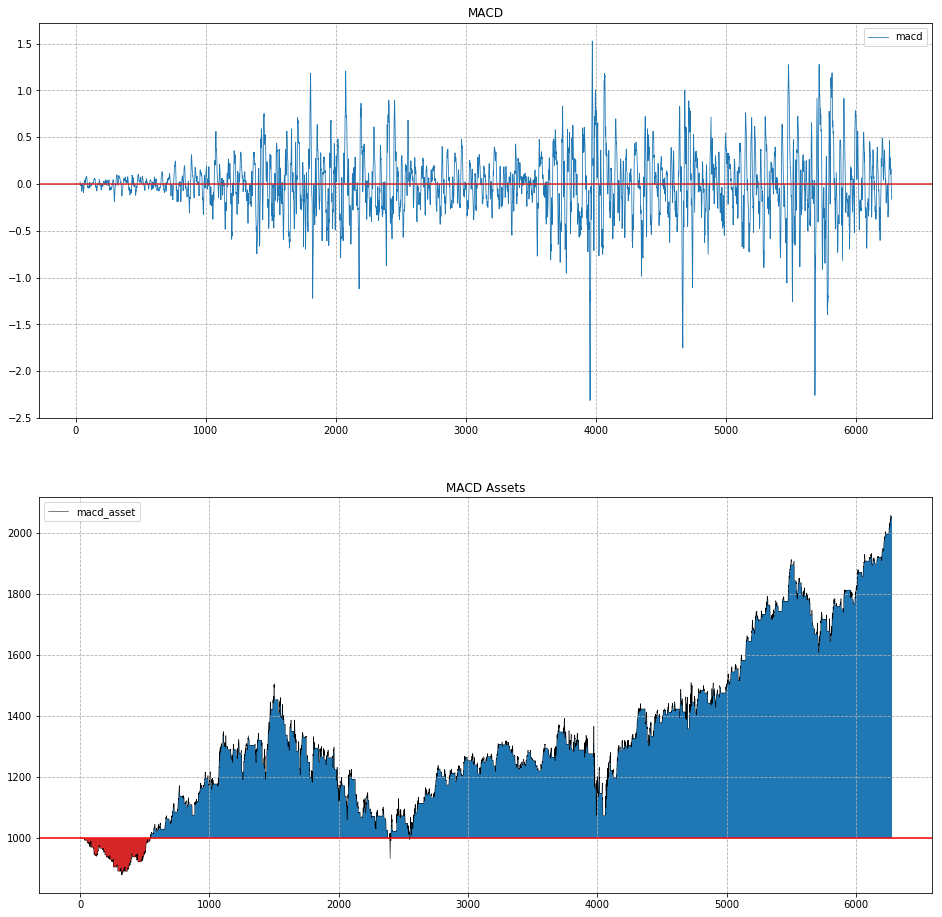

Init Capital: 1000
5399.94555202
2510.68004927
4350.1340775
3061.02664671
2099.72186655
2075.57026343
846.800539652


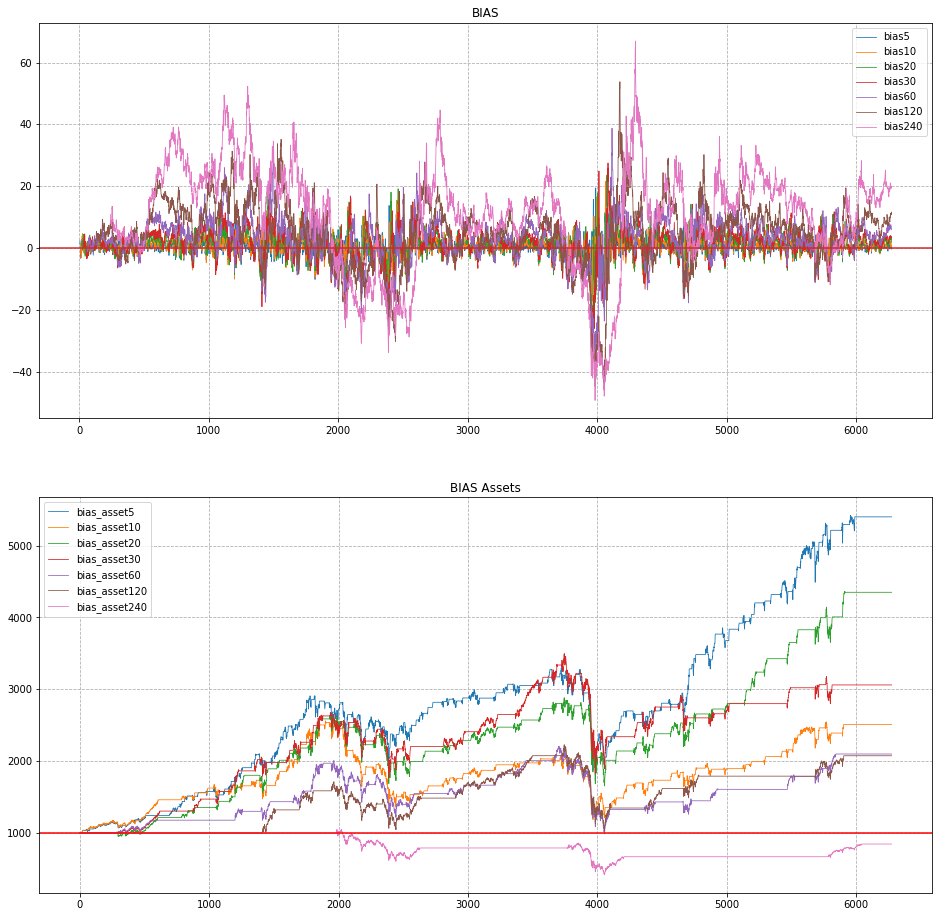

Init Capital: 1000
1209.99152181
1063.30436529
3764.78183991
2238.34466878
5084.51866244
8484.38038405
9729.06379345


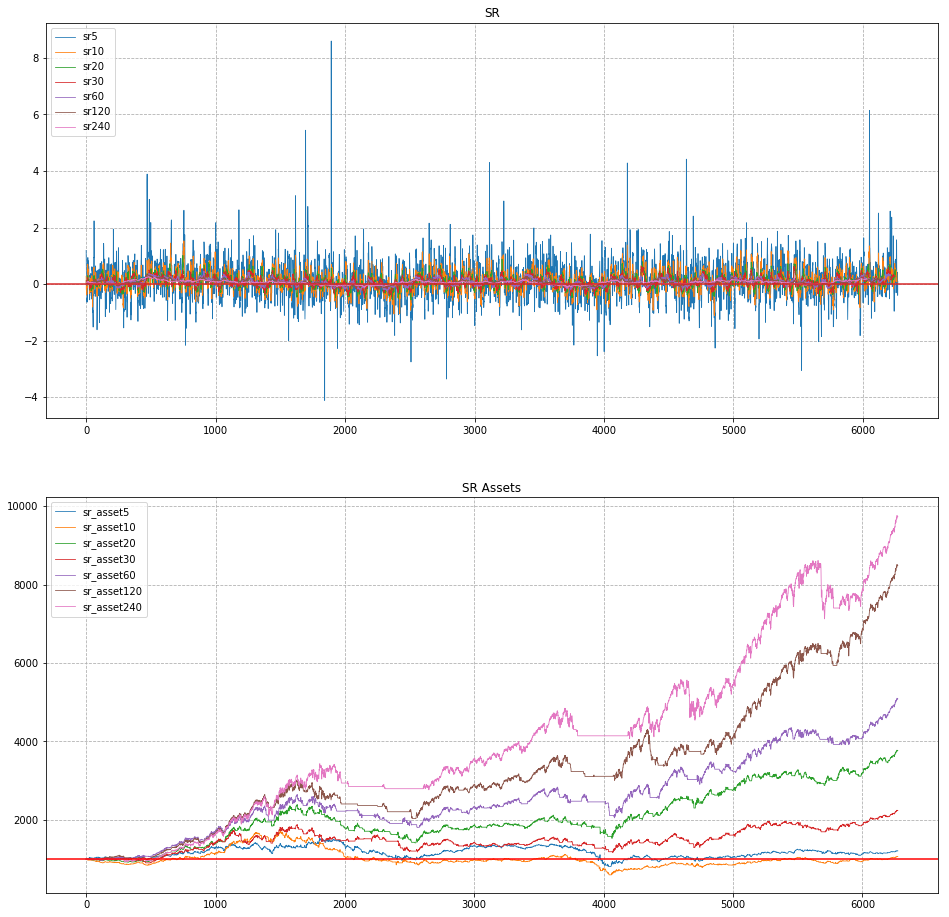

In [3]:
## Test Indicators

# read
data = ReadData("SPY.csv")
datalen = len(data)

# plot close
plt.figure(figsize=(16, 8))
plt.plot(data["Adj Close"])
plt.title("Adj Close")
plt.grid(linestyle='--')
plt.legend()
plt.show()

# parameters
capital = 1000
days = datalen
start_day = datalen - days

# plot indicators
indicators = ["ma", "ema", "kd", "rsi", "macd", "bias", "sr"]
periods = [5, 10, 20, 30, 60, 120, 240]
for i in indicators:
    TestIndicator(data, i, capital, days=str(days), periods=periods,
                  savefig=0, showfig=1, start_day=start_day)

1175.9229324


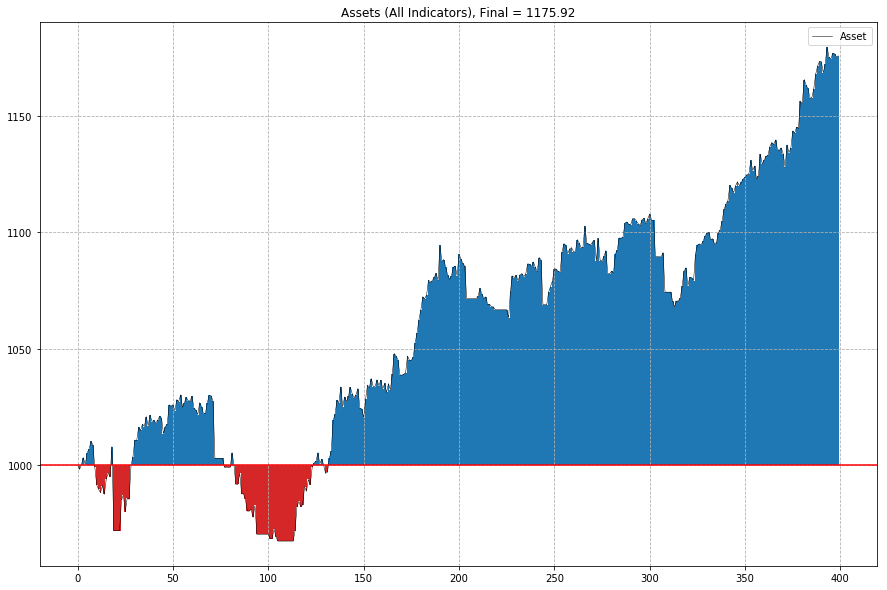

In [4]:
## Merge All Indicators

# read
data = ReadData("SPY.csv")
datalen = len(data)
days = 400
start_day = datalen - days
capital = 1000
close = np.array(data["Adj Close"])

# calculate all indicators
all_decisions, weights = [], []
for i in ["ma", "ema", "rsi", "bias", "sr"]:
    for p in [5, 10, 20, 30, 60, 120, 240]:
        all_decisions.append(eval(i.upper())(close, period=p)[0])
        weights.append(1)

all_decisions.append(eval("KD")(data)[0])
all_decisions.append(eval("MACD")(close)[0])
weights += [1, 1]

# merge
final_decision = MergeDecision(all_decisions, weights, datalen)

# evaluate
assets = Evaluate(close, final_decision, capital, start_day=start_day)

# plot graph
plt.figure(figsize=(15, 10))
plt.plot(assets[start_day:], label="Asset", color='k', linewidth='0.5')
PlotArea(plt.gca(), assets[start_day:], capital)

plt.axhline(y=capital, color="red")
plt.title("Assets (All Indicators), Final = %.2f" % assets[-1])
plt.grid(linestyle='--')
plt.legend()
#plt.gcf().savefig("eval_all.png")
plt.show()

1260.02743949


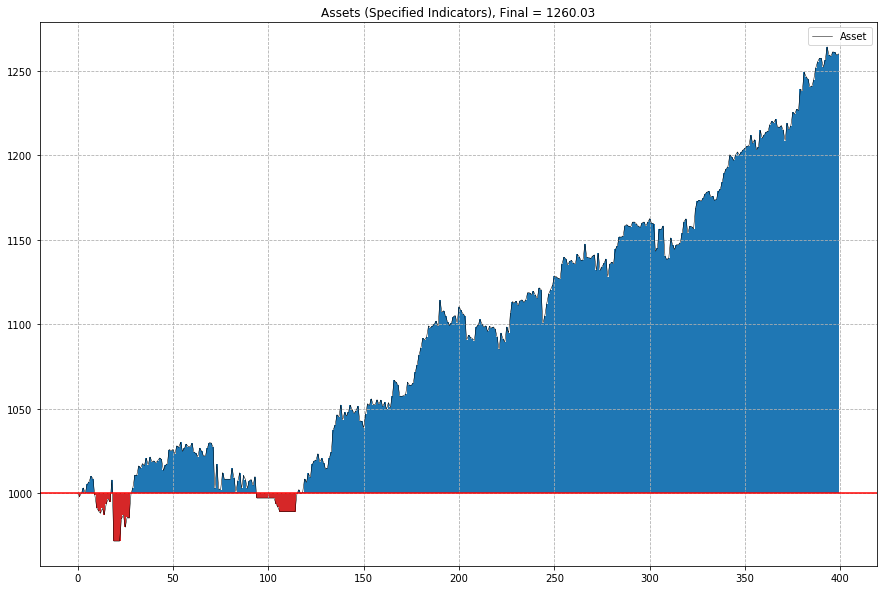

In [5]:
## Select Specific Indicators

# read
data = ReadData("SPY.csv")
datalen = len(data)
days = 400
start_day = datalen - days
capital = 1000
close = np.array(data["Adj Close"])

# select indicators
select_list = [
    {"type": "ema", "periods": [60, 120, 240], "weight": 1/3},
    {"type": "rsi", "periods": [5, 10], "weight": 1/2},
    {"type": "macd", "periods": [], "weight": 1},
    {"type": "bias", "periods": [5, 10, 20], "weight": 1/3},
    {"type": "sr", "periods": [30, 60, 120, 240], "weight": 1/4}
]

# compute indicators
decisions, weights = [], []

for i in select_list:
    if i["type"] in ["ma", "ema", "rsi", "bias", "sr"]:
        for p in i["periods"]:
            decisions.append(eval(i["type"].upper())(close, period=p)[0])
            weights.append(i["weight"])
    elif i["type"] is "kd":
        decisions.append(eval("KD")(data)[0])
        weights.append(i["weight"])
    elif i["type"] is "macd":
        decisions.append(eval("MACD")(close)[0])
        weights.append(i["weight"])

# merge
final_decision = MergeDecision(decisions, weights, datalen)

# evaluate
assets = Evaluate(close, final_decision, capital, start_day=start_day)

# plot graph
plt.figure(figsize=(15, 10))
plt.plot(assets[start_day:], label="Asset", color='k', linewidth='0.5')
PlotArea(plt.gca(), assets[start_day:], capital)

plt.axhline(y=capital, color="red")
plt.title("Assets (Specified Indicators), Final = %.2f" % assets[-1])
plt.grid(linestyle='--')
plt.legend()
#plt.gcf().savefig("eval_spec.png")
plt.show()